<a href="https://colab.research.google.com/github/HSKrab/data-course-sample/blob/main/cf_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 基礎建設

In [9]:
!pip install surprise

In [10]:
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
from collections import defaultdict
from scipy.stats import zscore 
import time
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

In [11]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [12]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-08 19:12:36--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.2’

All_Beauty.csv.2    100%[===================>]  14.78M  24.9MB/s    in 0.6s    

2022-01-08 19:12:37 (24.9 MB/s) - ‘All_Beauty.csv.2’ saved [15499476/15499476]

--2022-01-08 19:12:37--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.2’

meta_All_Beauty.jso 100%[===================>]   9.85M  17.7MB/s    in 0.6s   

In [13]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [14]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [15]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

####Modify the order

Sort by DATE, for calculating the new and all reviewers in EDA episode later.

In [16]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings.sort_values(by=['DATE'], inplace=True, ascending=True)
ratings

,asin,reviewerID,overall,unixReviewTime,DATE
256078,3317005939,AL2PQBKHP7LM4,5.0,947462400,2000-01-10
261647,0061073717,ATKPYXA8XFKGJ,5.0,957571200,2000-05-06
261646,0061073717,A2XMFX1BR0IJFJ,5.0,959990400,2000-06-03
256161,B000050B62,A1U7T7UCCV3SBN,5.0,972777600,2000-10-29
5299,B000050FDP,A3RVIXD86WUT1E,5.0,973987200,2000-11-12
...,...,...,...,...,...
370903,B01HC6G4D6,A1RAXJN2Q4V20X,4.0,1538265600,2018-09-30
369982,B01GZWUSYY,A1M8YMS915ZK0B,1.0,1538265600,2018-09-30
368687,B01GIYE88G,A3RTH0S9XVBPVK,5.0,1538352000,2018-10-01
368798,B01GJQXRLC,A3ORA680FWE8SW,5.0,1538352000,2018-10-01


####Decide & Remove useless columns

統計每個 column 共有幾種數據，資訊過少或判斷參考性不大則消除該 column 縮減資料量。

In [17]:
for col in metadata:
  print(str(metadata[col].astype(str).nunique())+' data in '+col+' col.')

1 data in category col.
11 data in tech1 col.
13751 data in description col.
1 data in fit col.
32300 data in title col.
6482 data in also_buy col.
1 data in tech2 col.
7863 data in brand col.
230 data in feature col.
31949 data in rank col.
7894 data in also_view col.
32329 data in details col.
1 data in main_cat col.
1301 data in similar_item col.
20 data in date col.
3530 data in price col.
32488 data in asin col.
15737 data in imageURL col.
15737 data in imageURLHighRes col.


發現 metadata 中 index 425 至 828 之間，共 404 筆資料是跟之前的 index 重複的，將完全重複的 row 去掉。

In [18]:
print(len(metadata['asin']),len(set(metadata['asin'])))		
s,rep=set(),list()
for i,asin in enumerate(metadata['asin']):
  if asin not in s:
    s.add(asin)
  else:
    rep.append(i)
print(rep)
metadata=metadata.loc[metadata.astype(str).drop_duplicates().index]
metadata

32892 32488
[425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 62

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32887,[],,[],,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,,[],"2,145,325 in Beauty & Personal Care (",[],{'ASIN: ': 'B01HIWLLUK'},All Beauty,,,$9.95,B01HIWLLUK,[],[]
32888,[],,[],,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],,Salon Perfect,[],"1,639,713 in Beauty & Personal Care (",[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",All Beauty,,,,B01HJ1K3YK,[],[]
32889,[],,[],,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,,[],"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",All Beauty,,,$55.63,B01HJ84SGM,[],[]
32890,[],,[Brand new and high quality<br> Enables fast v...,,12 White Feather Shuttlecocks Birdies Badminto...,[],,GBSTORE,[],"965,673 in Beauty & Personal Care (",[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",All Beauty,,,$12.99,B01HJASD20,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


將資訊含量過少的 column 去掉。</br>
另外如main_cat全部欄位的資訊都是All Beauty，判斷無助於分析，因此也去掉。

In [19]:
a=[]
for i,asin in enumerate(metadata['main_cat']):
  if asin !='All Beauty':
    a.append(i)

if not a: print('Info of main_cat are all the same.')

metadata=metadata[['description','title','also_buy','brand','rank','also_view','details','price','asin']]
metadata

Info of main_cat are all the same.


,description,title,also_buy,brand,rank,also_view,details,price,asin
0,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},,6546546450
1,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",$44.99,7178680776
2,[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",$28.76,7250468162
3,[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,7367905066
4,[Lacto Calamine Skin Balance Daily Nourishing ...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",$12.15,7414204790
...,...,...,...,...,...,...,...,...,...
32887,[],"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,"2,145,325 in Beauty & Personal Care (",[],{'ASIN: ': 'B01HIWLLUK'},$9.95,B01HIWLLUK
32888,[],(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,"1,639,713 in Beauty & Personal Care (",[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,B01HJ1K3YK
32889,[],NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",$55.63,B01HJ84SGM
32890,[Brand new and high quality<br> Enables fast v...,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,"965,673 in Beauty & Personal Care (",[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",$12.99,B01HJASD20


####Specify the type of all columns

統一處理 metadata 各個 column 的資訊：</br>
description: str</br>
title: str</br>
also_buy/also_view: list</br>
brand: str</br>
rank: int or ''</br>
details: dict</br>
price: float or ''</br>

追加 ranktype: str (原先 rank 欄位後面的內容)

In [20]:
metadata['description'] = metadata['description'].apply(lambda x:x[0] if x else '')
metadata['title'] = metadata['title'].apply(lambda x:x if x else '')
metadata['also_buy'] = metadata['also_buy'].apply(lambda x:x if type(x) is list else [])
metadata['brand'] = metadata['brand'].apply(lambda x:x if x else '')
#metadata['rank'] = pd.to_numeric(metadata['rank'].str.split(expand = True)[0].str.replace(',', ''))
metadata['ranktype'] = metadata['rank'].apply(lambda x:x.split(' in ')[1].replace(' (', '') if type(x) is str else '')
metadata['rank'] = metadata['rank'].apply(lambda x:int(x.split(' ')[0].replace(',', '')) if type(x) is str else '')
metadata['also_view'] = metadata['also_view'].apply(lambda x:x if type(x) is list else [])
metadata['details'] = metadata['details'].apply(lambda x:x if type(x) is dict else {})
metadata['price'] = metadata['price'].apply(lambda x:float(x.replace('$','').replace(',','')) if x and len(x)<10 else '')

#Method 1: Combine title, brand, ranktype.
#metadata['trainstr']=metadata['title'].str.cat(metadata[['brand', 'ranktype']], sep=' ')
#metadata['trainstr']=metadata['trainstr'].apply(lambda x:''.join([c for c in x if c.isalnum() or c==' ' ]))
#Result: No sufficient RAM

#Method 2: Combine title, brand, ranktype, with brand replaced with XXXX and ranktype with XXXX
#XXXX means four randomized characters which x.isalnum() is True.
#metadata['trainstr']=metadata['title'].str.cat(metadata[['brand', 'ranktype']], sep=' ')
#metadata['trainstr']=metadata['trainstr'].apply(lambda x:''.join([c for c in x if c.isalnum() or c==' ' ]))
#Result: No sufficient RAM

metadata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,description,title,also_buy,brand,rank,also_view,details,price,asin,ranktype
0,Loud 'N Clear Personal Sound Amplifier allows ...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,2938573,[],{'ASIN: ': '6546546450'},,6546546450,Beauty & Personal Care
1,No7 Lift & Luminate Triple Action Serum 50ml b...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,872854,[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",44.99,7178680776,Beauty & Personal Care
2,No7 Stay Perfect Foundation now stays perfect ...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,956696,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",28.76,7250468162,Beauty & Personal Care
3,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,1870258,[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,7367905066,Beauty & Personal Care
4,Lacto Calamine Skin Balance Daily Nourishing L...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,67701,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",12.15,7414204790,Beauty & Personal Care
...,...,...,...,...,...,...,...,...,...,...
32887,,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,2145325,[],{'ASIN: ': 'B01HIWLLUK'},9.95,B01HIWLLUK,Beauty & Personal Care
32888,,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,1639713,[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,B01HJ1K3YK,Beauty & Personal Care
32889,,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,207410,"[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",55.63,B01HJ84SGM,Beauty & Personal Care
32890,Brand new and high quality<br> Enables fast vo...,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,965673,[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",12.99,B01HJASD20,Beauty & Personal Care


####Merge both ratings and metadata

Merge the metadata with the mean and count of overall of every asin. 

In [21]:
comb_mdata = metadata.set_index('asin')
comb_mdata['overall_mean'] = ratings.groupby(by=['asin']).mean()['overall']
comb_mdata['reviews_count'] = ratings.groupby(by=['asin']).size()
comb_mdata

,description,title,also_buy,brand,rank,also_view,details,price,ranktype,overall_mean,reviews_count
asin,,,,,,,,,,,
6546546450,Loud 'N Clear Personal Sound Amplifier allows ...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,2938573,[],{'ASIN: ': '6546546450'},,Beauty & Personal Care,2.5,2.0
7178680776,No7 Lift & Luminate Triple Action Serum 50ml b...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,872854,[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",44.99,Beauty & Personal Care,3.0,1.0
7250468162,No7 Stay Perfect Foundation now stays perfect ...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,956696,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",28.76,Beauty & Personal Care,5.0,1.0
7367905066,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,1870258,[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,Beauty & Personal Care,5.0,1.0
7414204790,Lacto Calamine Skin Balance Daily Nourishing L...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,67701,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",12.15,Beauty & Personal Care,4.4,15.0
...,...,...,...,...,...,...,...,...,...,...,...
B01HIWLLUK,,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,2145325,[],{'ASIN: ': 'B01HIWLLUK'},9.95,Beauty & Personal Care,5.0,1.0
B01HJ1K3YK,,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,1639713,[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,Beauty & Personal Care,1.0,1.0
B01HJ84SGM,,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,207410,"[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",55.63,Beauty & Personal Care,5.0,5.0


the other way without index being reset.

In [22]:
rat_g = ratings
rat_g['overall_mean'] = rat_g.groupby(by = ['asin'])['overall'].transform(lambda x: x.mean())
rat_g['reviews_count'] = rat_g.groupby(by = ['asin'])['overall'].transform(lambda x: len(x))
rat_g

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
256078,3317005939,AL2PQBKHP7LM4,5.0,947462400,2000-01-10,4.500000,4.0
261647,0061073717,ATKPYXA8XFKGJ,5.0,957571200,2000-05-06,5.000000,2.0
261646,0061073717,A2XMFX1BR0IJFJ,5.0,959990400,2000-06-03,5.000000,2.0
256161,B000050B62,A1U7T7UCCV3SBN,5.0,972777600,2000-10-29,4.250000,4.0
5299,B000050FDP,A3RVIXD86WUT1E,5.0,973987200,2000-11-12,4.214286,14.0
...,...,...,...,...,...,...,...
370903,B01HC6G4D6,A1RAXJN2Q4V20X,4.0,1538265600,2018-09-30,4.885714,140.0
369982,B01GZWUSYY,A1M8YMS915ZK0B,1.0,1538265600,2018-09-30,3.290323,31.0
368687,B01GIYE88G,A3RTH0S9XVBPVK,5.0,1538352000,2018-10-01,4.500000,6.0
368798,B01GJQXRLC,A3ORA680FWE8SW,5.0,1538352000,2018-10-01,4.333333,9.0


In [23]:
rat = rat_g[['asin', 'overall_mean', 'reviews_count']]
rat.drop_duplicates(subset='asin', inplace=True)
rat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,asin,overall_mean,reviews_count
256078,3317005939,4.500000,4.0
261647,0061073717,5.000000,2.0
256161,B000050B62,4.250000,4.0
5299,B000050FDP,4.214286,14.0
256259,B000050B69,4.500000,4.0
...,...,...,...
364002,B01EPFJFWE,4.000000,1.0
339117,B015PWYO7W,5.000000,1.0
360657,B01DOGOKNY,5.000000,1.0
350494,B01AE1TJV0,5.000000,1.0


In [24]:
metadata = pd.merge(metadata, rat, on = 'asin')
metadata

,description,title,also_buy,brand,rank,also_view,details,price,asin,ranktype,overall_mean,reviews_count
0,Loud 'N Clear Personal Sound Amplifier allows ...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,2938573,[],{'ASIN: ': '6546546450'},,6546546450,Beauty & Personal Care,2.5,2.0
1,No7 Lift & Luminate Triple Action Serum 50ml b...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,872854,[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",44.99,7178680776,Beauty & Personal Care,3.0,1.0
2,No7 Stay Perfect Foundation now stays perfect ...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,956696,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",28.76,7250468162,Beauty & Personal Care,5.0,1.0
3,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,1870258,[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,7367905066,Beauty & Personal Care,5.0,1.0
4,Lacto Calamine Skin Balance Daily Nourishing L...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,67701,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",12.15,7414204790,Beauty & Personal Care,4.4,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32481,,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,2145325,[],{'ASIN: ': 'B01HIWLLUK'},9.95,B01HIWLLUK,Beauty & Personal Care,5.0,1.0
32482,,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,1639713,[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,B01HJ1K3YK,Beauty & Personal Care,1.0,1.0
32483,,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,207410,"[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",55.63,B01HJ84SGM,Beauty & Personal Care,5.0,5.0
32484,Brand new and high quality<br> Enables fast vo...,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,965673,[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",12.99,B01HJASD20,Beauty & Personal Care,1.0,1.0


In [25]:
if all(metadata['overall_mean']): print('Every asin in metadata has been purchased and rated.')

Every asin in metadata has been purchased and rated.


####Extra

Investigate the reviews of those ranktype which is NOT Beauty & Personal Care, in order to decide whether to delete all of them or not.

In [26]:
meta_vc = metadata['ranktype'].value_counts()
type_count = meta_vc.to_list()
ranktype = meta_vc.index.to_list()

rt_d = {'ranktype':[], 'reviews_count':[], 'reviews_mean':[]}
for rt in ranktype:
  rc = metadata[metadata['ranktype']==rt][['reviews_count']]
  rt_d['ranktype'].append(rt)
  rt_d['reviews_count'].append(rc.sum()[0])
  rt_d['reviews_mean'].append(rc.mean()[0])

rt_d.update({'ranktype_count':type_count})
rt_d = pd.DataFrame(rt_d)
rt_d[['ranktype', 'ranktype_count', 'reviews_count', 'reviews_mean']]


,ranktype,ranktype_count,reviews_count,reviews_mean
0,Beauty & Personal Care,31539,341723.0,10.834935
1,Beauty &amp; Personal Care,474,19885.0,41.951477
2,,402,4159.0,10.345771
3,Grocery & Gourmet Food,35,244.0,6.971429
4,Health & Household,19,108.0,5.684211
5,Toys & Games,3,9.0,3.000000
6,Sports & Outdoors,3,18.0,6.000000
7,Health &amp; Household,2,25.0,12.500000
8,Baby,2,2.0,1.000000
9,Grocery &amp; Gourmet Food,2,18.0,9.000000


index = 5 以上的 ranktype 因為所含的商品太少，reviews_mean 參考價值不大。僅就 ranktype_count 為 10 以上的 ranktype 而言，第二大類 Beauty & amp; Personal Care 所有 asin 的平均銷售量 (reviews_mean) 有壓倒性勝利，因此判斷不適合直接刪除最大 ranktype 以外的所有商品數據。若欲刪除，則應可嘗試刪除 index = 3,4 的兩類。

Observe the ratings data of ranktype, where the top 3 ranktype ('Beauty & Personal Care', 'Beauty &amp; Personal Care', '') is excluded here. 

In [27]:
metadata[
         (metadata['ranktype']!='Beauty & Personal Care') & 
         (metadata['ranktype']!='Beauty &amp; Personal Care') &
         (metadata['ranktype']!='')
         ][['asin','ranktype','overall_mean','reviews_count']].sort_values('reviews_count')

,asin,ranktype,overall_mean,reviews_count
31977,B01GS5NLH4,Toys & Games,5.000000,1.0
17218,B00POF5TRA,Toys & Games,5.000000,1.0
10667,B00GKH887E,Health & Household,2.000000,1.0
9912,B00F2T1KDU,Grocery & Gourmet Food,5.000000,1.0
19827,B00VTVVAZ8,Health & Household,5.000000,1.0
...,...,...,...,...
1945,B000ZMBSNG,Health &amp; Household,4.750000,24.0
13728,B00KLGCW6I,Grocery & Gourmet Food,4.285714,28.0
2150,B0014ZA9QU,Grocery & Gourmet Food,4.238095,42.0
30984,B01FL6ORN8,Grocery & Gourmet Food,4.604651,43.0


Observe the ratings data of best-sold asin of the above table.

In [28]:
ratings[ratings['asin']=='B00I3F4QSQ']

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
157095,B00I3F4QSQ,A23NX3FWE3VXEG,5.0,1519084800,2018-02-20,3.673469,49.0
157094,B00I3F4QSQ,AM6XONCGBHX8E,3.0,1519430400,2018-02-24,3.673469,49.0
157093,B00I3F4QSQ,A24IZB5SD8M1A8,5.0,1519516800,2018-02-25,3.673469,49.0
157092,B00I3F4QSQ,AV5OLF46X3U0S,2.0,1519603200,2018-02-26,3.673469,49.0
157091,B00I3F4QSQ,A20SSYF3GGZUDL,5.0,1520380800,2018-03-07,3.673469,49.0
157090,B00I3F4QSQ,AN9V9IC3KDF6P,1.0,1520640000,2018-03-10,3.673469,49.0
157089,B00I3F4QSQ,A1A7YGL2VTZHWX,4.0,1520726400,2018-03-11,3.673469,49.0
157088,B00I3F4QSQ,A1F3EVK4QVLIR4,5.0,1521158400,2018-03-16,3.673469,49.0
157087,B00I3F4QSQ,A1SX2AFZ2WJID8,1.0,1521158400,2018-03-16,3.673469,49.0
157124,B00I3F4QSQ,A3FUTFM82SLQDR,1.0,1521417600,2018-03-19,3.673469,49.0


以資料集來說算是新的商品。

##EDA

####Title

濾掉不必要的 column 後，title column 有 32300 種值，然而 asin column 卻有 32488 種值。</br>
證明了不同商品卻有相同 title 的狀況。

In [29]:
for col in metadata:
  print(str(metadata[col].astype(str).nunique())+' data in '+col+' col.')
metadata.shape

13274 data in description col.
32298 data in title col.
6482 data in also_buy col.
7863 data in brand col.
31876 data in rank col.
7894 data in also_view col.
32327 data in details col.
3526 data in price col.
32486 data in asin col.
14 data in ranktype col.
1810 data in overall_mean col.
374 data in reviews_count col.


(32486, 12)

####RankType

In [30]:
m_ranktype = metadata['ranktype'].value_counts()
print(f'There are {len(m_ranktype)} ranktypes. (None ranktype is included.)')
print(f'The most ranktype is {m_ranktype.index[0]}.')
print(f"And it's {m_ranktype.max()/m_ranktype.sum()*100:.1f}% of all ranktypes.")
m_ranktype

There are 14 ranktypes. (None ranktype is included.)
The most ranktype is Beauty & Personal Care.
And it's 97.1% of all ranktypes.


Beauty & Personal Care        31539
Beauty &amp; Personal Care      474
                                402
Grocery & Gourmet Food           35
Health & Household               19
Toys & Games                      3
Sports & Outdoors                 3
Health &amp; Household            2
Baby                              2
Grocery &amp; Gourmet Food        2
Clothing, Shoes & Jewelry         2
Tools & Home Improvement          1
Home & Kitchen                    1
Automotive                        1
Name: ranktype, dtype: int64

####Brand

In [31]:
metadata['brand'].value_counts()

                                     15569
VAGA                                   252
L'Oreal Paris                          110
Betty Dain                              82
EG GIFTS                                79
                                     ...  
RICH                                     1
LUCIDO                                   1
Professional Quality Pocket Combs        1
Hott Place                               1
Revlon / Almay                           1
Name: brand, Length: 7863, dtype: int64

####Price

The max price of all time: 2149.0


Text(0.5, 0, 'US dollars')

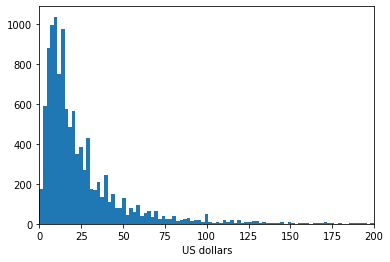

In [32]:
price=metadata[metadata['price'] != '']
print('The max price of all time: '+str(max(price['price'])))
plt.hist(metadata[metadata['price'] != '']['price'],bins=1000)
plt.xlim(0,200)
plt.xlabel('US dollars')

####New Reviewers

改寫自 Ana 同學的第一週作業 EDA 的內容，在此統計「原始資料」中購買者和商品的重複率，發現：<br>
<ul>
<li>9成以上的商品被重複購入過。(32,586/371,345 < 10%)
<li>8.7成左右的評論來自新用戶。(324,038/371,345 ~ 87%)
<li>在評論數據庫裡，有商品不在原始的商品數據庫。(32,586 > 32,488)</li>

In [33]:
print(f'Total orders: {ratings.shape[0]:,}')
print(f'Total products: {metadata.asin.nunique():,}')
print(f'Unrepeated products: {ratings.asin.nunique():,}')
print(f'Unrepeated users: {ratings.reviewerID.nunique():,}')

Total orders: 371,345
Total products: 32,486
Unrepeated products: 32,586
Unrepeated users: 324,038


統計每個月的評價數中，總評價數和新用戶的評價數

In [34]:
date,reviewer,new_reviewer=[],[],[]

month=datetime.date(2000,1,1)
count,s=0,set()
start,end=0,0
while month<=datetime.date(2018,9,1):
  while ratings['DATE'].iloc[end]<month+relativedelta(months=1):
    if ratings['reviewerID'].iloc[end] not in s:
      count+=1
    end+=1
  s=set(ratings['reviewerID'].iloc[:end])
  reviewer.append(len(ratings['reviewerID'].iloc[start:end]))
  new_reviewer.append(count)
  #new_reviewer.append(len(set(ratings['reviewerID'].iloc[start:end])))
  date.append(month)
  start=end
  count=0
  month+=relativedelta(months=1)

對時間做圖後發現：
<br>
<ul>
<li>2016, 17年訂單數到達高峰後逐月下降。
<li>每月訂單中，新進用戶的訂單數量佔比極高。</li>
</ul>

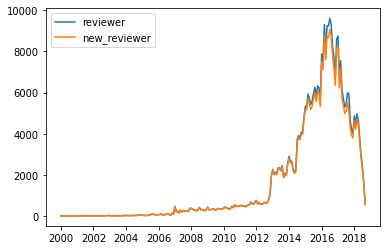

In [35]:
plt.plot(date,reviewer,label='reviewer')
plt.plot(date,new_reviewer,label='new_reviewer')
plt.legend()

####Asin & Reviewer

The count of asin that has n reviews in rating data.

The most popular asin of all time is B000FOI48G.
With 8672 reviews left.
There are 41.4% asins have been bought once. Most of the asin have been bought multiple times.


Text(0, 0.5, 'count of asin')

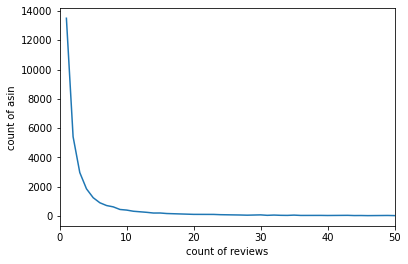

In [140]:
#ratings.groupby(by = 'asin')[['overall']].count().value_counts()
rat_as_c = ratings['asin'].value_counts()
print(f'The most popular asin of all time is {rat_as_c.index[0]}.')
print(f'With {rat_as_c.max()} reviews left.')
rat_as_c_c = rat_as_c.value_counts()
print(f'There are {rat_as_c_c.max()/ratings.asin.nunique()*100:.1f}% asins have been bought once. Most of the asin have been bought multiple times.')
rat_as_c_c = rat_as_c_c.to_dict()
rat_as_c_c = {key:[rat_as_c_c[key]] for key in sorted(rat_as_c_c.keys())}
plt.plot(list(rat_as_c_c.keys()), list(rat_as_c_c.values()))
plt.xlim(0,50)
plt.xlabel('count of reviews')
plt.ylabel('count of asin')

The count of reviews left by every reviewer.

In [37]:
rat_rev_c = ratings['reviewerID'].value_counts()
print(f'The reviewer who has left the most reviews is {rat_rev_c.index[0]}.')
print(f'With {rat_rev_c.max()} reviews left.')
rat_rev_c

The reviewer who has left the most reviews is A2GJX2KCUSR0EI.
With 27 reviews left.


A2GJX2KCUSR0EI    27
A1KSC91G9AIY2Z    23
A22CW0ZHY3NJH8    21
A1EGCED01USBA9    21
AENH50GW3OKDA     20
                  ..
AAGQAZXRUEF22      1
AYU36GRX072FG      1
A2TIAJ8N9G487J     1
A2QDOM9ZWU4QX7     1
A1YYLG8ARIJFYX     1
Name: reviewerID, Length: 324038, dtype: int64

The count of reviewers that left n reviews.</br>
The accumulation count of reviewers that left ≥n reviews.</br>
There is be only 6.27% of reviewers that left equal to or more than 3 reviews. </br>
If we consider the repeated purchased asin by single reviewer, the ratio will be even smaller.

In [38]:
rat_rev_c_c = rat_rev_c.value_counts()
print(f'There are about {rat_rev_c_c.max()/rat_rev_c.sum()*100:.1f}% reviewers left only one review.')
rat_dic = rat_rev_c_c.to_dict()
rat_dic = {key:[rat_dic[key]] for key in sorted(rat_dic.keys())}
for key in rat_dic:
  above = sum([rat_dic[k][0]*k/ratings.shape[0]*100 for k in rat_dic if k >= key])
  rat_dic[key].append(f'{above:.2f}%')
accumulate = pd.DataFrame(rat_dic,index=['count of reviewers left n reviews', '% of count that ≥n'])
accumulate 

There are about 77.5% reviewers left only one review.


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,20,21,23,27
count of reviewers left n reviews,287784,30135,3702,1019,774,455,66,35,24,16,10,7,3,2,1,1,2,1,1
% of count that ≥n,100.00%,22.50%,6.27%,3.28%,2.18%,1.14%,0.41%,0.28%,0.21%,0.15%,0.11%,0.08%,0.05%,0.04%,0.04%,0.03%,0.02%,0.01%,0.01%


重複買家購入相同物品/重複買家 的 評價筆數 (共 19,218/83,561 筆)

In [39]:
ratings.duplicated(subset=['reviewerID'], keep=False).value_counts()

False    287784
True      83561
dtype: int64

In [40]:
ratings.duplicated(subset=['asin','reviewerID'], keep=False).value_counts()

False    352127
True      19218
dtype: int64

重複買家購入相同物品且給同評分/重複買家 的 評價筆數 (共 18,837/83,561 筆)</br>
居然有將近 400 筆資料是同買家對於同商品有不同評分XDDDDD

In [41]:
ratings.duplicated(subset=['asin','reviewerID','overall'], keep=False).value_counts()

False    352508
True      18837
dtype: int64

Take the user who bought most for example.</br>
The case that the same reviewer gave the same asin different rating. </br>
What's wrong with him/her??? Orzzzz

In [42]:
ratings[(ratings['reviewerID']=='A2GJX2KCUSR0EI')&(ratings['asin']=='B0012XPRO8')]

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
56200,B0012XPRO8,A2GJX2KCUSR0EI,3.0,1422316800,2015-01-27,4.219626,214.0
64725,B0012XPRO8,A2GJX2KCUSR0EI,3.0,1422316800,2015-01-27,4.219626,214.0
56187,B0012XPRO8,A2GJX2KCUSR0EI,4.0,1429833600,2015-04-24,4.219626,214.0
64712,B0012XPRO8,A2GJX2KCUSR0EI,4.0,1429833600,2015-04-24,4.219626,214.0


A boring reviewerID who left almost the same overall ratings, which is 5.0.</br>
That's why I feel like normalizing the overall ratings which were left by the reviewerIDs who purchased multiple times.

In [43]:
ratings[(ratings['reviewerID']=='A1EGCED01USBA9')]

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
276076,B005KDW4GK,A1EGCED01USBA9,5.0,1411603200,2014-09-25,4.700000,20.0
193881,B00W259T7G,A1EGCED01USBA9,5.0,1413936000,2014-10-22,4.516729,2959.0
193882,B00W259T7G,A1EGCED01USBA9,5.0,1413936000,2014-10-22,4.516729,2959.0
193850,B00W259T7G,A1EGCED01USBA9,5.0,1416182400,2014-11-17,4.516729,2959.0
260273,B000IQVVGI,A1EGCED01USBA9,4.0,1419724800,2014-12-28,4.285714,28.0
193793,B00W259T7G,A1EGCED01USBA9,4.0,1419724800,2014-12-28,4.516729,2959.0
43137,B000IQSU0I,A1EGCED01USBA9,5.0,1420243200,2015-01-03,4.571429,63.0
193779,B00W259T7G,A1EGCED01USBA9,5.0,1420243200,2015-01-03,4.516729,2959.0
193707,B00W259T7G,A1EGCED01USBA9,5.0,1425513600,2015-03-05,4.516729,2959.0
273944,B004VW27ZY,A1EGCED01USBA9,5.0,1429142400,2015-04-16,5.000000,1.0


This guy left relatively useful overall ratings.

In [44]:
ratings[(ratings['reviewerID']=='AENH50GW3OKDA')]

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
97980,B004IQA3TU,AENH50GW3OKDA,5.0,1375056000,2013-07-29,4.681818,176.0
285243,B00BTPPVH2,AENH50GW3OKDA,5.0,1380240000,2013-09-27,5.000000,5.0
313198,B00NXARBCY,AENH50GW3OKDA,5.0,1415923200,2014-11-14,4.833333,6.0
315582,B00P5N13SK,AENH50GW3OKDA,5.0,1416528000,2014-11-21,4.428571,7.0
98854,B004ROV2UM,AENH50GW3OKDA,5.0,1420848000,2015-01-10,4.300000,40.0
176791,B00OR1D37A,AENH50GW3OKDA,5.0,1432166400,2015-05-21,3.273438,128.0
104672,B005K0T4OI,AENH50GW3OKDA,5.0,1435017600,2015-06-23,4.547619,84.0
315356,B00P0H2D3A,AENH50GW3OKDA,5.0,1435104000,2015-06-24,4.000000,8.0
196549,B00X918PRC,AENH50GW3OKDA,5.0,1440460800,2015-08-25,4.032258,31.0
138806,B00BSY3IG0,AENH50GW3OKDA,5.0,1440547200,2015-08-26,4.000000,16.0


####Overall rating

評論分數分佈統計

In [45]:
ratings['overall'].value_counts()

5.0    229549
4.0     52687
1.0     39261
3.0     29555
2.0     20293
Name: overall, dtype: int64

(array([3.53130e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 1.30000e+01, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.90000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.80000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.77230e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 3.00000e+00, 1.00000e+00, 8.60000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 4.67000e+02, 0.00000e+00, 0.00000e+00,
        7.00000e+00, 7.90000e+01, 0.00000e+00, 1.10000e+01, 0.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        2.60060e+04, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        7.00000e+00, 1.70000e+01, 2.00000e+00, 1.47000e+02, 1.00000e+00,
        1.00000e+01, 1.00000e+00, 1.22600e+03, 2.00000e+00, 1.00000e+00,
        1.00000e+01, 3.07000e+02, 1.00000e+00, 4.40

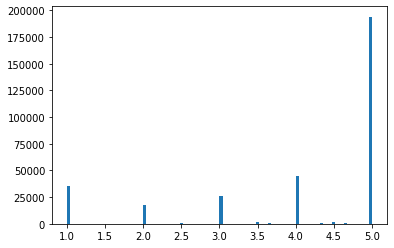

In [46]:
x = ratings.groupby(by='reviewerID').mean()['overall'].to_list() #.value_counts()
plt.hist(x, bins = 100)

雖然大部分商品都被買過不只一次，只被買過一次的商品僅佔所有 asin 的 3.6%，但相較其他被買次數，只被買過一次的 asin 還是相對較多 (見 Asin & Reviewer 部分的第一張圖)，因此平均評分為整數的商品數明顯較多。

## 推薦相關 function

####資料切分

In [47]:
def cut(predict,ratings=ratings):
  """
  let predict be the first day of any month.
  """
  train = ratings[
    (ratings['DATE'] < str(predict))
  ]
  test = ratings[
    (ratings['DATE'] >= str(predict)) & 
    (ratings['DATE'] < str(predict+relativedelta(months=1)))
  ]
  return train,test

####dataframe 轉成 dictionary

In [48]:
def pd_to_dict(training_data):
    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        user_to_items[user][item] = rating

    return user_to_items

####Normalize 後轉 dictionary

In [49]:
def norm_to_dict(training_data):
    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }

    user_to_items = defaultdict(dict)
    thres = 3
    rvc = ratings['reviewerID'].value_counts().to_dict()
    
    all_r = [r for r in rvc if rvc[r] >= thres]
    print(len(all_r))
    for reviewer in all_r:
        r_nor = ratings[ratings['reviewerID'] == reviewer][['asin','reviewerID','overall']]
        r_nor = r_nor.groupby(by = ['reviewerID','asin']).mean()
        r_nor['zscore'] = zscore(r_nor['overall'])+3 if r_nor['overall'].value_counts().size > 1 else 3
        for row in r_nor.iterrows():
            row = dict(row)
            l = list(row.keys())
            user, item, rating = l[0], row[l[0]], row[l[1]]
            user_to_items[user][item] = rating
    return user_to_items

In [50]:
ratings[ratings['reviewerID']=='A3NFZN1GS1RKR9']

,asin,reviewerID,overall,unixReviewTime,DATE,overall_mean,reviews_count
194220,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194222,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194217,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194218,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194227,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194219,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194221,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
194225,B00W259T7G,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.516729,2959.0
43185,B000IQVVGI,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.285714,28.0
43151,B000IQSU0I,A3NFZN1GS1RKR9,5.0,1374192000,2013-07-19,4.571429,63.0


確認經由取平均、normalize 後得到的 overall 分數沒有異常

In [51]:
#norm_to_dict(ratings)

####過濾資料

In [52]:
def filtering(user_to_items, exe = True, threshold = 3):
    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = exe
    user_rating_threshold = threshold
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]
    
    return user_to_items

####轉置資料

In [53]:
def transpose(user_to_items):
    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    return item_to_users

####轉置矩陣展開（相似度）

In [54]:
def user_sim(item_to_users):
    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    return pre_user_similarity

####計算 user similarity matrix

In [55]:
def user_sim_mat(pre_user_similarity):
    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            #print(xy,xx,yy)
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    return user_similarity

#### 獲取推薦結果

In [56]:
def recom(users, user_similarity, user_to_items, k):
    recommendation = {}
    for user in users:
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user])
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1])
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []

    return recommendation

##評分資料 normalize 討論

EDA 中發現：
1. 滿分 (5分) 的佔所有評分的 62% 左右。且有找到給過大量評分的買家給分偏甜，沒有鑑別度的情況。
2. 有將近 400 筆資料是同買家對於同商品有不同評分。
3. 結合以下的轉置特性研究，認為 normalize 較恰當。

####轉置特性研究

所有商品只給一種評分，相似度為1。

In [57]:
fake0 = {
    'user1':{'item1':1, 'item2':1},
    'user2':{'item1':3, 'item2':3},
    'user3':{'item1':5, 'item2':5}
}
user_sim_mat(user_sim(transpose(fake0)))

{'user1': [('user2', 1.0), ('user3', 1.0)],
 'user2': [('user1', 1.0), ('user3', 1.0)],
 'user3': [('user1', 1.0), ('user2', 1.0)]}

這樣的情況下相似度不會為1。

In [58]:
fake1 = {
    'user1':{'item1':1, 'item2':1, 'item3':5},
    'user2':{'item1':2, 'item2':2, 'item3':5}
}
user_sim_mat(user_sim(transpose(fake1)))

{'user1': [('user2', 0.9715365547505717)],
 'user2': [('user1', 0.9715365547505717)]}

這樣的情況下相似度不會為1。

In [59]:
fake2 = {
    'user1':{'item1':1, 'item2':2},
    'user2':{'item1':2, 'item2':3},
    'user3':{'item1':3, 'item2':4}
}
user_sim_mat(user_sim(transpose(fake2)))

{'user1': [('user2', 0.9922778767136677), ('user3', 0.9838699100999074)],
 'user2': [('user3', 0.9984603532054125), ('user1', 0.9922778767136677)],
 'user3': [('user2', 0.9984603532054125), ('user1', 0.9838699100999074)]}

我希望以上的三個 fake 的評分舉例，能夠 normalize 到一樣的評分，進而得到相似度為1。因為有可能並不是因為個人喜好差異，而是個人「習慣於給出怎麼樣的評分」的差異。例如：</br>
1. 我起評分都是4，沒有特別瑕疵一律給5。
2. 因為我喜好分明，所以習慣只給1 or 3 or 5。
3. 我習慣以3為基準，特別好才會給到4，爛到爆就扣到2。

####Normalize 方法研究

Refer to the example of stack overflow, modify to fit our dataset. </br>
https://stackoverflow.com/questions/59668597/z-score-normalization-in-pandas-dataframe-python

In [60]:
# Create a sample df
df = pd.DataFrame({'num_1': [2,2,3]})

# Calculate the zscores and drop zscores into new column
df['num_1_zscore'] = zscore(df['num_1'],nan_policy='omit') if df['num_1'].value_counts().size>1 else 3 #let the mean overall be at 3.0

display(df)

,num_1,num_1_zscore
0,2,-0.707107
1,2,-0.707107
2,3,1.414214


先以在 Asin & Reviewer 裡檢討過的這位使用者，針對「明明相同產品卻給出不同評價」這件事來處理。</br>
將這位使用者重複購買過的產品評分做平均。因此本使用者對於 B0012XPRO8 這個產品的平均為3.5。

In [62]:
r_nor = ratings[ratings['reviewerID']=='A2GJX2KCUSR0EI'][['asin','reviewerID','overall']]
#r_nor['asin'].astype(str).nunique()
r_nor = r_nor.groupby(by=['reviewerID','asin']).mean()#.to_dict()['overall']
#y = {next(iter(x))[0]:{key[1]:val for key,val in x.items()}}
#y
r_nor

overall
reviewerID     asin               
A2GJX2KCUSR0EI B0012XPRO8      3.5
               B001F51RAG      5.0
               B001MW1MK2      5.0
               B002RZZXYE      5.0
               B004AI7NXA      3.0
               B0050PSRKA      5.0
               B00592MMPA      4.0
               B00FOGYS44      4.0
               B00GHJOM2U      3.0
               B00MGK9Z8U      5.0
               B00WV02MLM      5.0
               B00X4DKZKU      4.0
               B00XMR53RI      5.0
               B00YB5YZME      5.0
               B011KWHC84      5.0
               B013J5W6ZE      5.0
               B016QSRYR6      4.0
               B018Z4OKG2      4.0
               B019XF1EES      5.0
               B01AQYVEC2      5.0
               B01B1G0SBM      5.0
               B01B27JD3Y      4.0
               B01BBUZZ4S      5.0
               B01H4LWGIG      4.0

接著將這位使用者的所有評分做 normalize 於新增的 zscore。

In [63]:
r_nor['zscore'] = zscore(r_nor['overall'])+3
r_nor
#r_d = r_nor['zscore'].to_dict()
#r = {next(iter(r_d))[0]:{key[1]:val for key,val in r_d.items()}}
#r
d=defaultdict(dict)
for row in r_nor.iterrows():
        row = dict(row)
        #print(list(row.keys()))
        l=list(row.keys())
        user,item,rating=l[0],row[l[0]],row[l[1]]
        d[user][item]=rating
        #user = row['reviewerID']
        #item = row['asin']
        #rating = float(row['overall'])
        #user_to_items[user][item] = rating
d

defaultdict(dict,
            {'A2GJX2KCUSR0EI': {'B0012XPRO8': 1.5362445493188954,
              'B001F51RAG': 3.778593324830374,
              'B001MW1MK2': 3.778593324830374,
              'B002RZZXYE': 3.778593324830374,
              'B004AI7NXA': 0.7887949574817359,
              'B0050PSRKA': 3.778593324830374,
              'B00592MMPA': 2.283694141156055,
              'B00FOGYS44': 2.283694141156055,
              'B00GHJOM2U': 0.7887949574817359,
              'B00MGK9Z8U': 3.778593324830374,
              'B00WV02MLM': 3.778593324830374,
              'B00X4DKZKU': 2.283694141156055,
              'B00XMR53RI': 3.778593324830374,
              'B00YB5YZME': 3.778593324830374,
              'B011KWHC84': 3.778593324830374,
              'B013J5W6ZE': 3.778593324830374,
              'B016QSRYR6': 2.283694141156055,
              'B018Z4OKG2': 2.283694141156055,
              'B019XF1EES': 3.778593324830374,
              'B01AQYVEC2': 3.778593324830374,
              'B01B1G

## 產生推薦

分別以原先 sample code 的原始數據以及 normalized 的評分來產生推薦。
推薦法分為以下六種：</br>
1. cf-user
2. cf-item
3. cf-surprise
4. cf-user + rule-based
5. cf-item + rule-based
6. cf-surprise + rule-based

####cut the ratings data

In [126]:
"""
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
"""
ratings_trainings,ratings_testings = cut(predict=datetime.date(2018,9,1))
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

####cf-user-based

In [128]:
# header: user_id,item_id,rating,timestamp

def recommender_cf_us(training_data, norm = False, users=[], k=10):

    if not norm:
      user_to_items = pd_to_dict(training_data)
    else:
      user_to_items = norm_to_dict(training_data)
    print("total users before filtering: ", len(user_to_items))

    user_to_items = filtering(user_to_items, exe = True, threshold = 3)
    print("total users  after filtering: ", len(user_to_items))

    item_to_users = transpose(user_to_items)

    pre_user_similarity = user_sim(item_to_users)

    user_similarity = user_sim_mat(pre_user_similarity)

    recommendation = recom(users, user_similarity, user_to_items, k)

    return recommendation

ratings_by_cfus = recommender_cf_us(ratings_trainings, True, users)
ratings_by_cfus

6119


KeyboardInterrupt: ignored

####cf-item-based

In [133]:
def recommender_cf_it(training_data, norm = False, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    if not norm:
      item_to_users = defaultdict(dict)
      for _, row in training_data.iterrows():
          row = dict(row)
          user = row['reviewerID']
          item = row['asin']
          rating = float(row['overall'])
          item_to_users[item][user] = rating
    else:
          item_to_users = norm_to_dict(training_data)

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_cfit = recommender_cf_it(ratings_trainings, False, users)
ratings_by_cfit

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B000EE9XYG',
  'B007SA3AUW',
  'B000FVHRXC',
  'B001U4RGOS',
  'B01CRWLLX8',
  'B004E4GHRS',
  'B00B0SA1SC',
  'B006IB5T4W',
  'B00L88S190',
  'B00NV5QEEC'],
 'A174Y

####cf-surprise

In [118]:
def recommender_cf_sp(training_data, users=[], k=10, user_based=False, algo=KNNBasic):

    training_data = training_data[training_data['DATE'] >= '2017-08-01']
    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

ratings_by_cfsp = recommender_cf_sp(ratings_trainings, users)
ratings_by_cfsp

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': ['B012Z7IHHI',
  'B019Z9L2SK',
  'B000R8V1

In [134]:
def with_rule_based(cf_rec, k=10):
    cut_rating = ratings[
      (ratings['DATE'] >= '2018-08-01') & 
      (ratings['DATE'] < '2018-09-01')
      ]
    re = list(cut_rating['asin'].value_counts().keys())[:k]
    for user in cf_rec:
        re_copy = re.copy()
        while len(cf_rec[user]) < k:
            most = re_copy.pop(0)
            if most not in cf_rec[user]:
                cf_rec[user].append(most)
    return cf_rec

In [137]:
with_rule_based(ratings_by_cfus, k = 10)

{'A100XQFWKQ30O2': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B0119Q9FYU'],
 'A103T1QOGFCSEH': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B0119Q9FYU'],
 'A106UKKSJ2KXPF': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B0119Q9FYU'],
 'A10A7GV4D5A11V': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B0119Q9FYU'],
 'A1119JJ37ZLB8R': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B0119Q9FYU'],
 'A113UOOLBSZN52': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01A

## 結果評估

In [119]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

In [120]:
evaluate(ratings_testings_by_user, recommender_cf_it(ratings_trainings, False, users))

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

0.0

In [138]:
cfus = evaluate(ratings_testings_by_user, recommender_cf_us(ratings_trainings, False, users))
cfit = evaluate(ratings_testings_by_user, recommender_cf_it(ratings_trainings, False, users))
cfsp = evaluate(ratings_testings_by_user, recommender_cf_sp(ratings_trainings, users))
cfusrb = evaluate(ratings_testings_by_user, with_rule_based(recommender_cf_us(ratings_trainings, False, users)))
cfitrb = evaluate(ratings_testings_by_user, with_rule_based(recommender_cf_it(ratings_trainings, False, users)))
cfsprb = evaluate(ratings_testings_by_user, with_rule_based(recommender_cf_sp(ratings_trainings, users)))

cfus_n = evaluate(ratings_testings_by_user, recommender_cf_us(ratings_trainings, True, users))
cfit_n = evaluate(ratings_testings_by_user, recommender_cf_it(ratings_trainings, True, users))
cfusrb_n = evaluate(ratings_testings_by_user, with_rule_based(recommender_cf_us(ratings_trainings, True, users)))
cfitrb_n = evaluate(ratings_testings_by_user, with_rule_based(recommender_cf_it(ratings_trainings, True, users)))

print('==============Without Normalization==============')
print(f'cf-user-based: {cfus}')
print(f'cf-item-based: {cfit}')
print(f'cf-surprise: {cfsp}')
print(f'cf-user-based + rule-based: {cfusrb}')
print(f'cf-item-based + rule-based: {cfitrb}')
print(f'cf-surprise + rule-based: {cfsprb}')
print('\n')
print('==================Normalization==================')
print(f'cf-user-based: {cfus_n}')
print(f'cf-item-based: {cfit_n}')
print(f'cf-user-based + rule-based: {cfusrb_n}')
print(f'cf-item-based + rule-based: {cfitrb_n}')

total users before filtering:  323489
total users  after filtering:  4793
data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q